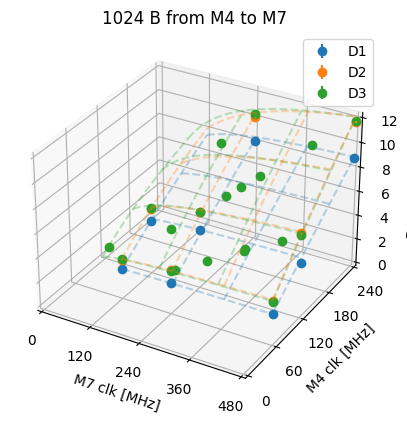

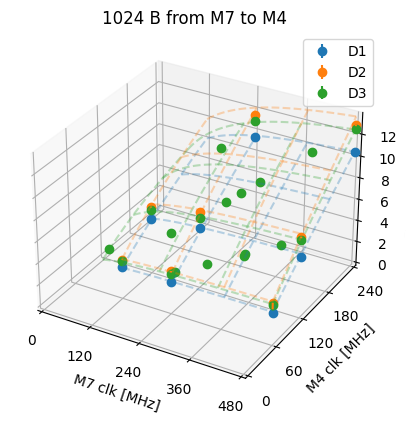

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from setup_paths import *
import measurement
import visu_3d
import linear_model
import visu_common

mems = visu_common.get_mems(MEASUREMENTS_PATH, r'D[0-9]')
meas_type = 'datarate'
size = [1024]
model_path = os.path.join(MODELS_PATH, 'models.json')

cmap = mpl.cm.tab10.colors

for direction in ['r', 's']:
    ax = plt.figure().add_subplot(111, projection='3d')
    for j, mem in enumerate(mems):
        clocks = visu_common.get_clocks_in_folder(
            os.path.join(MEASUREMENTS_PATH, mem), prefix=f'meas_{direction}_',
            clock_lambda=lambda m7, m4: m4 >= 60)
        
        # Measured data
        data = np.ndarray((len(clocks), 3, 1))
        for i, (m7, m4) in enumerate(clocks):
            dir_prefix = os.path.join(MEASUREMENTS_PATH, mem, f'meas_{direction}_{m7}_{m4}')
            # timer clock is always the same as the m4 core's clock
            data[i] = measurement.get_and_calc_meas(m4, dir_prefix, size, meas_type)
        visu_3d.errorbar_3d(clocks, data, ax, mem, cmap[j])
        
        # Predictions by the model
        model_long = linear_model.LinearModel(model_path, mem, direction)
        m7, m4, pred = model_long.get_grid_for_range(clocks, size, meas_type)
        visu_3d.model_grid(m7, m4, pred, ax, mpl.colors.to_rgba(cmap[j], 0.3))
    visu_3d.setup_ax(ax, direction, meas_type, size)
# show graph
plt.show()

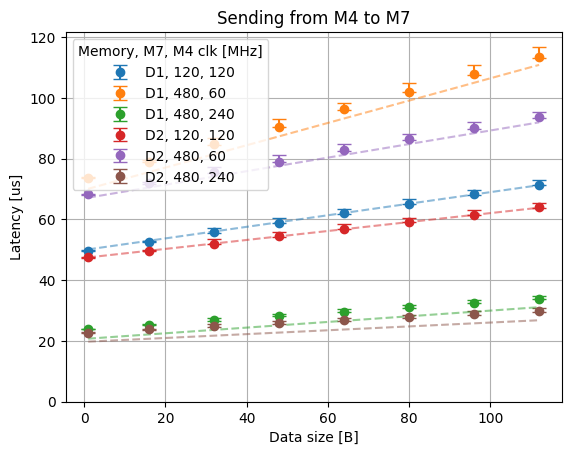

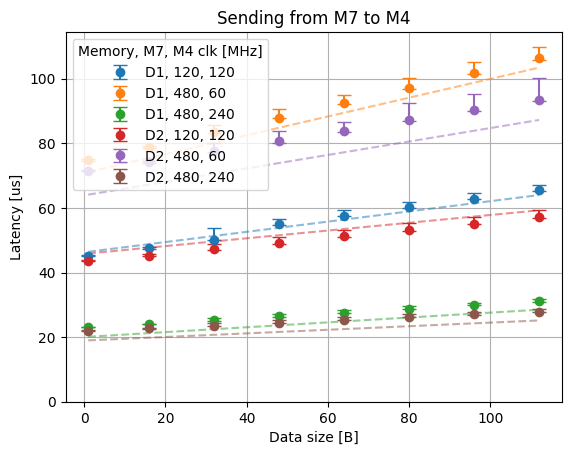

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from setup_paths import *
import visu_common
import measurement
import visu
import linear_model
configs = [{'mem': 'D1', 'clk': (120, 120)},
           {'mem': 'D1', 'clk': (480, 60)},
           {'mem': 'D1', 'clk': (480, 240)},
           {'mem': 'D2', 'clk': (120, 120)},
           {'mem': 'D2', 'clk': (480, 60)},
           {'mem': 'D2', 'clk': (480, 240)},]
meas_type = 'latency'

cmap = mpl.colormaps['tab10'].colors
dir = f'{configs[0]["mem"]}/meas_r_{configs[0]["clk"][0]}_{configs[0]["clk"][1]}'
dir = os.path.join(MEASUREMENTS_PATH, dir)
sizes = sorted(visu_common.get_sizes(dir, size_lambda=lambda s: s < 120))
long_model_path = os.path.join(MODELS_PATH, 'models_long.json')
short_model_path = os.path.join(MODELS_PATH, 'models.json')
model_long = linear_model.LinearModel(long_model_path, configs[0]['mem'], 'r')
model_short = linear_model.LinearModel(short_model_path, configs[0]['mem'], 'r')

for direction in ['r', 's']:
    # Measurement data
    data = np.ndarray((len(configs), 3, len(sizes)))
    for i, config in enumerate(configs):
        mem = config['mem']
        m7, m4 = config['clk']
        dir = os.path.join(MEASUREMENTS_PATH,  
                           f'{config["mem"]}/meas_{direction}_{m7}_{m4}')

        data[i] = measurement.get_and_calc_meas(m4, dir, sizes, meas_type)
    data = measurement.upper_lower_from_minmax(data)
    plt.figure()
    visu.errorbars(configs, sizes, data, cmap, if_line=False)
    
    preds = np.ndarray((len(configs), len(sizes)))
    # Model predictions
    for i, config in enumerate(configs):
        mem, (m7, m4) = config['mem'], config['clk']
        model_long.set_model(mem, direction)
        pred = model_long.get_output(m7, m4, sizes, meas_type)
        preds[i] = pred
        visu.model_plot(sizes, pred, m7, m4, mem, cmap[i])
        # model_short.set_model(mem, direction)
        # pred = model_short.get_output(m7, m4, sizes, meas_type)
        # visu.model_plot(sizes, pred, m7, m4, mem, cmap[i])
    visu.setup_errorbars(meas_type, direction)

In [3]:
import os
import json
import numpy as np
from setup_paths import *
import visu_common
import measurement
import linear_model

mems = visu_common.get_mems(MEASUREMENTS_PATH, pattern=r'D[0-9](_idcache_mpu_ncacheable)?')
meas_type = 'latency'
size = 16380
test_size_lambda = lambda s: s <= size
clock_lambda = (lambda m7, m4: m4 >= 60)

for json_path in ['models.json', 'models_long.json']:
    mse_dict = {}
    lin_model = linear_model.LinearModel(os.path.join(MODELS_PATH, json_path),
                                         mem, direction)
    for mem in mems:
        for direction in ['r', 's']:
            lin_model.set_model(mem, direction)
            y_model_list, y_test_list = [], []
            clocks = visu_common.get_clocks_in_folder(
                    os.path.join(MEASUREMENTS_PATH, mem),
                    prefix=f'meas_{direction}_', clock_lambda=clock_lambda)
            for m7, m4 in clocks:
                dir_prefix = os.path.join(MEASUREMENTS_PATH,
                                          mem,
                                          f'meas_{direction}_{m7}_{m4}')
                sizes = sorted(visu_common.get_sizes(dir_prefix,
                                                        size_lambda=test_size_lambda))
                y_test = measurement.get_and_calc_meas(m4, dir_prefix, sizes, meas_type)
                y_test_list.append(y_test[0, :]) # mean and column

                y_model = lin_model.get_output(m7, m4, sizes, meas_type)
                y_model_list.append(y_model)

            y_test_vector = np.hstack(y_test_list)
            y_model_vector = np.hstack(y_model_list)

            mse = linear_model.get_mse(y_model_vector, y_test_vector, axis=0) / np.mean(y_test)
            if mem in mse_dict:
                mse_dict[mem][direction] = mse
            else:
                mse_dict[mem] = {direction: mse}
    print(mse_dict)
    mse_file = os.path.join(MODELS_PATH, json_path.replace('models', f'mse{size}'))
    with open(mse_file, 'w') as file:
        json.dump(mse_dict, file, indent=4)

{'D1': {'r': 1.839302102706003, 's': 1.3027970538154927}, 'D1_idcache_mpu_ncacheable': {'r': 0.2775678297064443, 's': 0.20746481122189256}, 'D2': {'r': 0.46451954246464144, 's': 3.1324871699412116}, 'D2_idcache_mpu_ncacheable': {'r': 0.8356449518106421, 's': 0.11111199554402824}, 'D3': {'r': 0.1733200893155722, 's': 2.5844328865114545}, 'D3_idcache_mpu_ncacheable': {'r': 0.20282232950575876, 's': 0.04980702111565734}}
{'D1': {'r': 1.0631006405355403, 's': 0.549947579973837}, 'D1_idcache_mpu_ncacheable': {'r': 0.10282909221935668, 's': 0.0076718626145089}, 'D2': {'r': 0.36519719106346876, 's': 1.696594403479841}, 'D2_idcache_mpu_ncacheable': {'r': 0.7582997454509114, 's': 0.018561561643677556}, 'D3': {'r': 0.13531921476241363, 's': 1.1918598296195253}, 'D3_idcache_mpu_ncacheable': {'r': 0.1421976539964584, 's': 0.0044493569097324645}}


In [4]:
from setup_paths import *
with open(os.path.join(MODELS_PATH, 'mse256.json'), 'r') as short:
    mse_short = json.load(short)
with open(os.path.join(MODELS_PATH, 'mse256_long.json'), 'r') as long:
    mse_long = json.load(long)
for direction in ['r', 's']:
    print('\t\\midrule\n\t'
    + ('M4-M7' if direction=='r' else 'M7-M4')
    + '& \\multicolumn{2}{ c }{}\\\\\n'
    '\t\\midrule')
    for (ks, vs), (kl, vl) in zip(mse_short.items(), mse_long.items()):
        mem = ks.replace('_idcache_mpu_ncacheable', ' gyorsítótárral')
        print(f'\t{mem} & {vs[direction]:.3f} & {vl[direction]:.3f}\\\\')

	\midrule
	M4-M7& \multicolumn{2}{ c }{}\\
	\midrule
	D1 & 5.314 & 5.733\\
	D1 gyorsítótárral & 0.268 & 0.705\\
	D2 & 3.726 & 3.741\\
	D2 gyorsítótárral & 0.372 & 0.830\\
	D3 & 1.903 & 1.919\\
	D3 gyorsítótárral & 0.209 & 0.399\\
	\midrule
	M7-M4& \multicolumn{2}{ c }{}\\
	\midrule
	D1 & 4.445 & 4.957\\
	D1 gyorsítótárral & 1.080 & 1.567\\
	D2 & 3.404 & 8.431\\
	D2 gyorsítótárral & 0.719 & 0.910\\
	D3 & 1.931 & 3.224\\
	D3 gyorsítótárral & 1.286 & 1.305\\
